In [142]:
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd

BOARD_SIZE = 100

In [143]:
def create_snakes_and_ladders(board_size, num_snakes, num_ladders):
    """
    Generates random positions for snakes and ladders on a board.
    
    Args:
        board_size (int): Size of the board
        num_snakes (int): Number of snakes to place
        num_ladders (int): Number of ladders to place
        
    Returns:
        tuple: (snakes dict, ladders dict)
    """
    snakes = {}
    ladders = {}
    used_tiles = set()

    def generate_endpoints(entity_type, used_tiles):
        while True:
            if entity_type == "snake":
                start_tile = random.randint(2, board_size - 1)
            else:  # ladder
                start_tile = random.randint(2, board_size - 3)

            if start_tile in used_tiles:
                continue

            if entity_type == "snake":
                end_tile = random.randint(1, start_tile - 1)
            else:  # ladder
                end_tile = random.randint(start_tile + 1, board_size - 1)

            if end_tile in used_tiles or end_tile == start_tile:
                continue

            valid_placement = True
            for s_start, s_end in snakes.items():
                if start_tile == s_start or start_tile == s_end or end_tile == s_start or end_tile == s_end:
                    valid_placement = False
                    break
            if not valid_placement:
                continue
                
            for l_start, l_end in ladders.items():
                if start_tile == l_start or start_tile == l_end or end_tile == l_start or end_tile == l_end:
                    valid_placement = False
                    break
            if not valid_placement:
                continue

            break

        used_tiles.add(start_tile)
        used_tiles.add(end_tile)
        return start_tile, end_tile

    # Generate Snakes
    for _ in range(num_snakes):
        start, end = generate_endpoints("snake", used_tiles)
        snakes[start] = end

    # Generate Ladders
    for _ in range(num_ladders):
        start, end = generate_endpoints("ladder", used_tiles)
        ladders[start] = end

    return snakes, ladders

In [144]:
def simulate_game(board_size, snakes, ladders, record_positions=False, record_entity_triggers=False):
    """
    Simulates a single game of Snakes and Ladders.
    
    Args:
        board_size (int): Size of the board
        snakes (dict): Dictionary of snake positions
        ladders (dict): Dictionary of ladder positions
        record_positions (bool): Whether to record all positions visited
        record_entity_triggers (bool): Whether to record snake/ladder triggers
        
    Returns:
        tuple: (turns taken, positions visited, entity triggers)
    """
    position = 0
    turns = 0
    positions_visited = [] if record_positions else None
    entity_triggers = [] if record_entity_triggers else None

    if record_positions:
        positions_visited.append(position)

    while position < board_size:
        roll = random.randint(1, 6)
        new_position = position + roll

        if new_position > board_size:
            new_position = board_size - (new_position - board_size)

        position = new_position
        turns += 1

        if record_positions:
            positions_visited.append(position)

        if position in snakes:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = snakes[position]
            if record_positions:
                positions_visited.append(position)
        elif position in ladders:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = ladders[position]
            if record_positions:
                positions_visited.append(position)

    return turns, positions_visited, entity_triggers


In [145]:

def create_transition_matrix(board_size, snakes, ladders):
    """
    Creates a transition matrix for the Snakes and Ladders Markov model.
    """
    num_states = board_size + 1
    transition_matrix = pd.DataFrame(0.0, index=range(num_states), columns=range(num_states))

    for current_tile in range(num_states):
        if current_tile == board_size:
            transition_matrix.loc[current_tile, current_tile] = 1.0
            continue

        probabilities = [0.0] * num_states
        for roll in range(1, 7):
            next_position = current_tile + roll
            
            if next_position > board_size:
                next_position = board_size - (next_position - board_size)
            
            if next_position in snakes:
                next_position = snakes[next_position]
            elif next_position in ladders:
                next_position = ladders[next_position]

            probabilities[next_position] += 1/6.0

        for next_state, prob in enumerate(probabilities):
            transition_matrix.loc[current_tile, next_state] = prob

    return transition_matrix

def calculate_expected_turns_markov(transition_matrix, board_size):
    """
    Calculates expected number of turns using Markov chain analysis.
    """
    n = board_size
    Q = transition_matrix.iloc[:n, :n].copy()
    I = pd.DataFrame(np.identity(n), index=range(n), columns=range(n))
    
    try:
        N = np.linalg.inv(I - Q)
        ones = np.ones(n)
        expected_turns = N.dot(ones)
        return expected_turns[0]
    except np.linalg.LinAlgError as e:
        print("Matrix inversion failed. Check transition matrix structure.")
        raise e

def calculate_steady_state_distribution(transition_matrix, board_size, initial_state=0, num_iterations=500):
    """
    Calculates the steady-state distribution of tile occupation probabilities.
    """
    num_states = board_size + 1
    state_distribution = pd.Series([0.0] * num_states, index=range(num_states))
    state_distribution[initial_state] = 1.0

    for _ in range(num_iterations):
        state_distribution = state_distribution.dot(transition_matrix)

    return state_distribution

In [146]:
def plot_turn_distribution(turn_counts, num_snakes, num_ladders, num_simulations):
    """
    Plots the distribution of turns taken to complete games.
    """
    plt.figure(figsize=(10, 6))
    
    # Determine bin size
    bin_size = max(1, (max(turn_counts) - min(turn_counts)) // 20)
    
    plt.hist(turn_counts, bins=range(min(turn_counts), max(turn_counts) + bin_size, bin_size),
             align='left', rwidth=0.8, color='skyblue', edgecolor='black', density=True)
    plt.xlabel("Number of Turns")
    plt.ylabel("Probability")
    plt.title(f"Turn Distribution\n({num_snakes} Snakes, {num_ladders} Ladders, {num_simulations} Simulations)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(min(turn_counts), max(turn_counts) + 1, bin_size))
    plt.tight_layout()
    plt.show()

def plot_board_heatmap(all_positions_visited, board_size, snakes, ladders, num_simulations):
    """
    Creates a heatmap showing frequency of visits to each board position.
    """
    tile_counts = Counter()
    for positions_list in all_positions_visited:
        tile_counts.update(positions_list)

    board_grid = np.zeros((10, 10))
    for tile in range(1, board_size + 1):
        row = (tile - 1) // 10  
        col = (tile - 1) % 10
        if row % 2 == 1:
            col = 9 - col
        board_grid[9 - row, col] = tile_counts.get(tile, 0)

    plt.figure(figsize=(12, 10))
    sns.heatmap(board_grid, annot=False, fmt="d", cmap="viridis",
                linewidths=.5, cbar_kws={'label': 'Visit Frequency'})
    
    # Add snake and ladder markers
    for start, end in snakes.items():
        row = (start - 1) // 10
        col = (start - 1) % 10 if row % 2 == 0 else 9 - ((start - 1) % 10)
        plt.text(col, 9 - row, 'S', color='white', ha='center', va='center', fontsize=8)
    
    for start, end in ladders.items():
        row = (start - 1) // 10
        col = (start - 1) % 10 if row % 2 == 0 else 9 - ((start - 1) % 10)
        plt.text(col, 9 - row, 'L', color='white', ha='center', va='center', fontsize=8)

    plt.title(f"Visit Frequency Heatmap\n({num_simulations} Simulations)")
    plt.xticks(np.arange(0, 10, 1), labels=[f'{i*10+1}-{(i+1)*10}' for i in range(10)])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
def plot_entity_trigger_heatmap(all_entity_triggers, board_size, snakes, ladders, num_simulations):
    """
    Creates a heatmap showing frequency of snake and ladder triggers.
    Fixed to show correct start→end labels for snakes and ladders.
    """
    tile_counts = Counter()
    for triggers in all_entity_triggers:
        tile_counts.update(triggers)

    board_grid = np.zeros((10, 10))
    
    # Fill the grid with trigger counts
    for tile in range(1, board_size + 1):
        row = (tile - 1) // 10
        col = (tile - 1) % 10
        if row % 2 == 1:
            col = 9 - col
        board_grid[9 - row, col] = tile_counts.get(tile, 0)

    plt.figure(figsize=(12, 10))
    
    # Create heatmap with white for zero values
    sns.heatmap(board_grid, annot=True, fmt=".0f", cmap="YlOrRd",
                linewidths=.5, cbar_kws={'label': 'Trigger Frequency'},
                mask=(board_grid == 0))
    
    # Add a background color for cells with zero values
    plt.gca().patch.set_facecolor('lightgray')
    
    # Add markers for snakes and ladders with correct start→end format
    for start, end in snakes.items():
        row = (start - 1) // 10
        col = (start - 1) % 10 if row % 2 == 0 else 9 - ((start - 1) % 10)
        plt.text(col, 9 - row, f'S{start}→{end}', color='darkblue', 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    for start, end in ladders.items():
        row = (start - 1) // 10
        col = (start - 1) % 10 if row % 2 == 0 else 9 - ((start - 1) % 10)
        plt.text(col, 9 - row, f'L{start}→{end}', color='darkgreen', 
                ha='center', va='center', fontsize=8, fontweight='bold')

    plt.title(f"Snake and Ladder Trigger Frequency\n({num_simulations} Simulations)")
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def run_analysis(board_size=100, num_snakes=10, num_ladders=10, num_simulations=10000):
    """
    Runs the complete analysis of the Snakes and Ladders game.
    """
    # Run simulations
    turn_counts = []
    all_positions_visited = []
    all_entity_triggers = []
    
    snakes, ladders = create_snakes_and_ladders(board_size, num_snakes, num_ladders)
    
    print("\nBoard Configuration:")
    print("Snakes:", {k: v for k, v in snakes.items()})
    print("Ladders:", {k: v for k, v in ladders.items()})
    
    for _ in range(num_simulations):
        turns, positions, triggers = simulate_game(board_size, snakes, ladders, 
                                                 record_positions=True, 
                                                 record_entity_triggers=True)
        turn_counts.append(turns)
        all_positions_visited.append(positions)
        all_entity_triggers.append(triggers)

    # Calculate metrics
    avg_turns = sum(turn_counts) / num_simulations
    print(f"\nSimulation Results:")
    print(f"Average Turns: {avg_turns:.2f}")
    print(f"Min Turns: {min(turn_counts)}")
    print(f"Max Turns: {max(turn_counts)}")

    # Markov analysis
    transition_matrix = create_transition_matrix(board_size, snakes, ladders)
    try:
        expected_turns = calculate_expected_turns_markov(transition_matrix, board_size)
        print(f"\nMarkov Analysis:")
        print(f"Expected Turns: {expected_turns:.2f}")
    except np.linalg.LinAlgError:
        print("Markov analysis failed due to singular matrix")

    # Generate visualizations
    plot_turn_distribution(turn_counts, num_snakes, num_ladders, num_simulations)
    plot_board_heatmap(all_positions_visited, board_size, snakes, ladders, num_simulations)
    plot_entity_trigger_heatmap(all_entity_triggers, board_size, snakes, ladders, num_simulations)
    


Board Configuration:
Snakes: {57: 8, 7: 1, 61: 28, 95: 10, 72: 55, 96: 51, 65: 44, 53: 26, 46: 12, 45: 39}
Ladders: {20: 22, 16: 68, 60: 84, 24: 67, 42: 75, 54: 88, 18: 78, 64: 91, 11: 82, 21: 58}

Simulation Results:
Average Turns: 52.21
Min Turns: 5
Max Turns: 487

Markov Analysis:
Expected Turns: 51.96


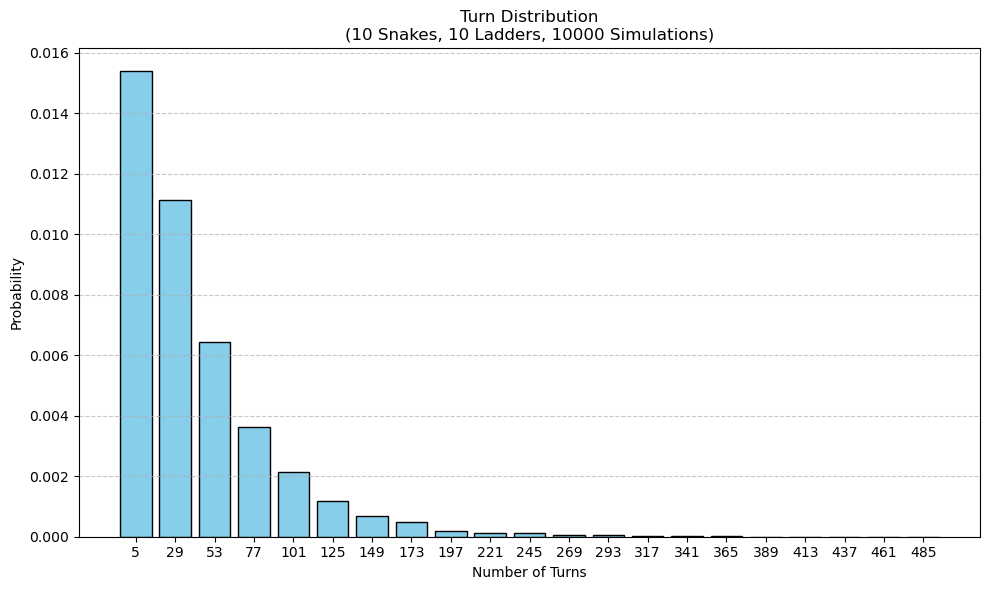

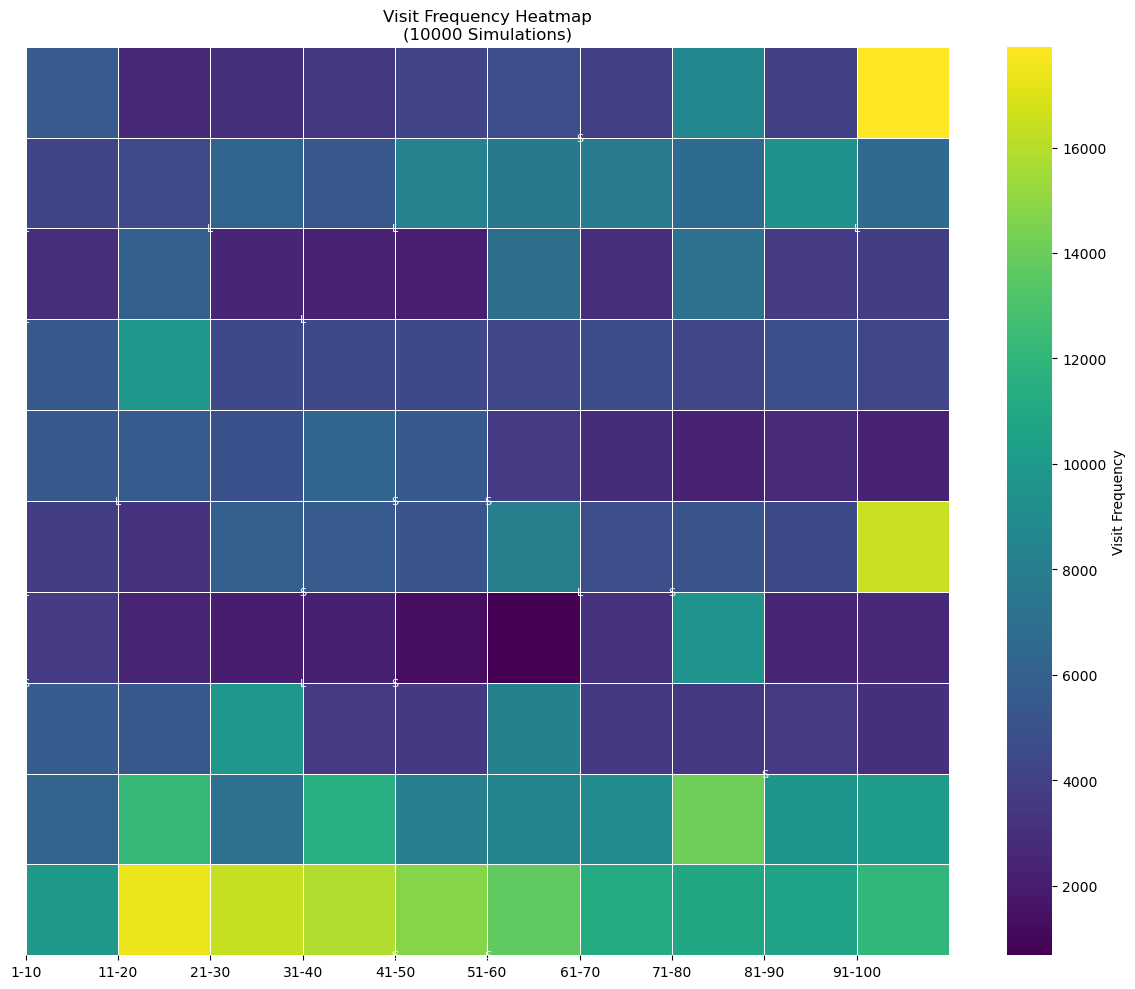

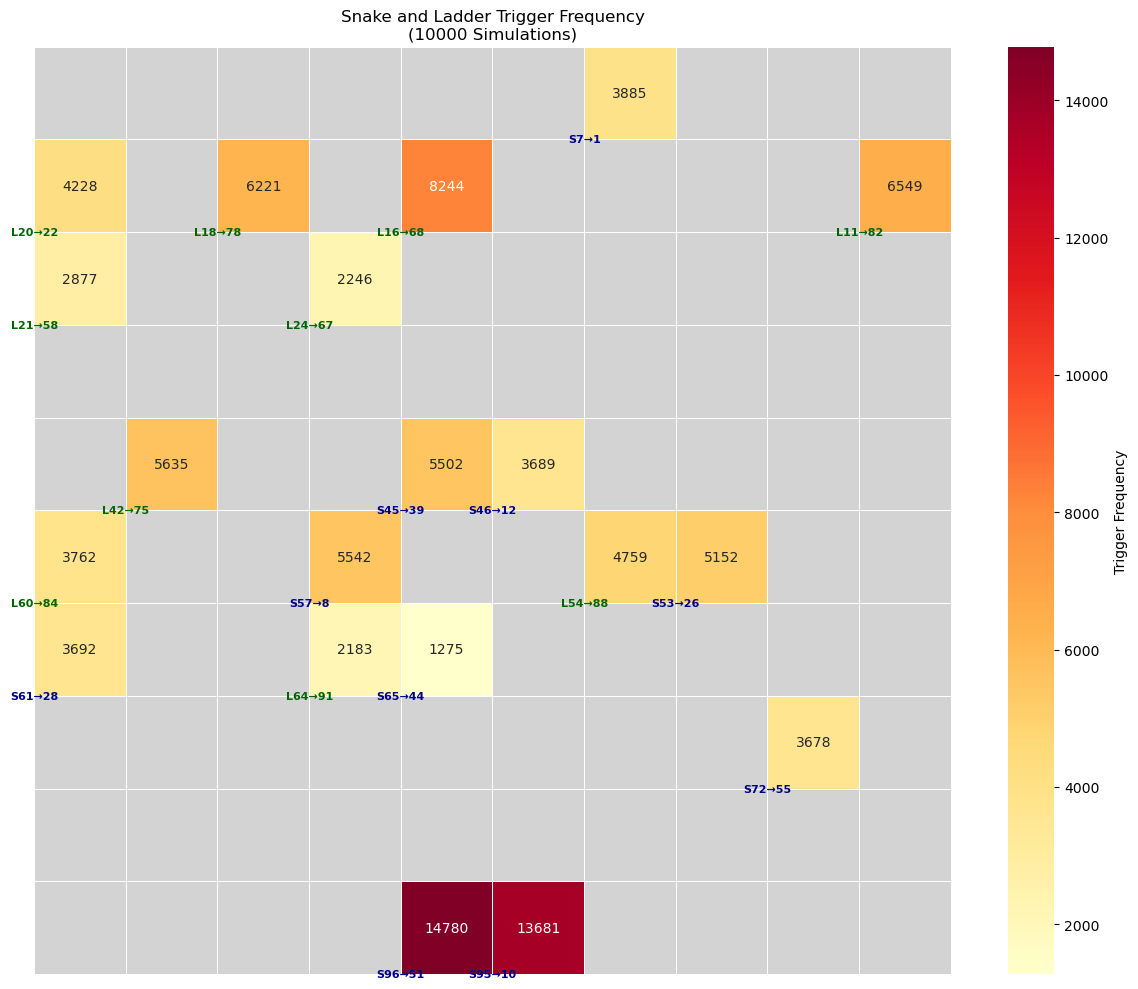

In [147]:
if __name__ == "__main__":
    run_analysis()